In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyecharts.options as opts
from pyecharts.charts import Bar, Line
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams["axes.unicode_minus"] = False

### 日收益率分布、仓位

In [2]:
stock_assets = pd.read_excel('data_asset.xlsx')
stock_assets["日期"] = pd.to_datetime(stock_assets["日期"])

In [3]:
stock_assets.head()

,日期,净值,日收益率,日收益额,仓位,总资产,股票总市值,净资金+国债,基金总份数,净入金
0,2025-04-14,1.000000,NaN,NaN,0.001964,772112.18,1516.2,770595.98,772112.1800,NaN
1,2025-04-15,0.999918,-0.000082,-63.00,0.105936,772049.18,81788.0,690261.18,772112.1800,NaN
2,2025-04-16,1.010089,0.010172,7853.08,0.270406,779902.26,210890.0,569012.26,772112.1800,NaN
3,2025-04-17,1.012302,0.002190,1708.12,0.213022,781610.38,166500.0,615110.38,772112.1800,200000.0
4,2025-04-18,1.013926,0.001604,1574.83,0.410101,983185.21,403205.0,579980.21,969681.7619,NaN


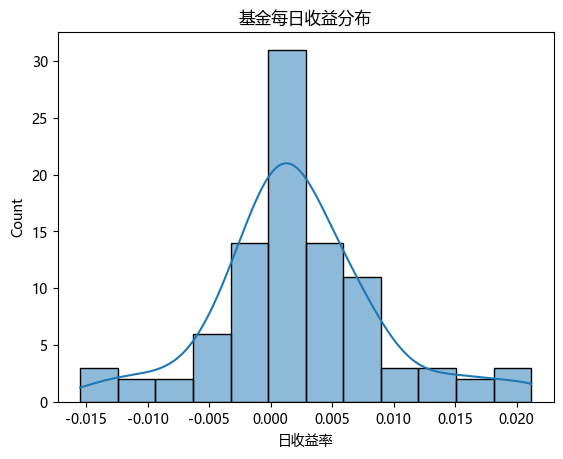

In [4]:
# 基金日收益率分布图
sns.histplot(stock_assets['日收益率'], kde = True)
plt.title('基金每日收益分布')
plt.show()

In [5]:
# 股票仓位变化图
print(f"平均股票仓位：{stock_assets['仓位'].mean():.2%}")
line = Line()
line.add_xaxis(xaxis_data=stock_assets["日期"].dt.strftime('%Y-%m-%d').tolist())
line.add_yaxis(
    series_name="股票仓位",
    stack="总量",
    y_axis=stock_assets["仓位"].tolist(),
    areastyle_opts=opts.AreaStyleOpts(opacity=0.5),
    label_opts=opts.LabelOpts(is_show=False),
)
line.set_global_opts(
    title_opts=opts.TitleOpts(title="股票仓位变化"),
    tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
    yaxis_opts=opts.AxisOpts(
        type_="value",
        axistick_opts=opts.AxisTickOpts(is_show=True),
        splitline_opts=opts.SplitLineOpts(is_show=True),
    ),
    xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
)
line.render_notebook()

平均股票仓位：24.10%


### 持股数、胜率、赔率

In [6]:
stock_holdings = pd.read_csv('data_hold.csv', encoding='utf-8')
stock_holdings["日期"] = pd.to_datetime(stock_holdings["日期"])
stock_holdings.sort_values(by=["日期"], inplace=True)
stock_holdings["证券代码"] = stock_holdings["证券代码"].astype(str).str.zfill(6)
stock_holdings["证券名称"] = stock_holdings["证券名称"].astype(str)
stock_holdings["总持仓"] = stock_holdings["总持仓"].astype(int)
stock_holdings["可变持仓"] = stock_holdings["可变持仓"].astype(int)
stock_holdings["参考市值"] = stock_holdings["参考市值"].astype(float)
stock_holdings["现价"] = stock_holdings["现价"].astype(float)
stock_holdings["涨幅"] = stock_holdings["涨幅"].astype(str)
stock_holdings["当日盈亏"] = stock_holdings["当日盈亏"].astype(float)

#### 持股数

In [7]:
stock_numbers = stock_holdings[stock_holdings["总持仓"] > 0].groupby("日期").size()
stock_numbers = pd.DataFrame(stock_numbers).reset_index()
stock_numbers.columns = ["日期", "持股数"]

In [8]:
# 股票仓位变化图
print(f"平均持股数：{stock_numbers['持股数'].mean():.2}")
line = Line()
line.add_xaxis(xaxis_data=stock_numbers["日期"].dt.strftime('%Y-%m-%d').tolist())
line.add_yaxis(
    series_name="持股数",
    stack="总量",
    y_axis=stock_numbers["持股数"].tolist(),
    areastyle_opts=opts.AreaStyleOpts(opacity=0.5),
    label_opts=opts.LabelOpts(is_show=False),
)
line.set_global_opts(
    title_opts=opts.TitleOpts(title="持股数变化"),
    tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
    yaxis_opts=opts.AxisOpts(
        type_="value",
        axistick_opts=opts.AxisTickOpts(is_show=True),
        splitline_opts=opts.SplitLineOpts(is_show=True),
    ),
    xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
)
line.render_notebook()

平均持股数：3.8


In [9]:
# 创建交易记录DataFrame
transactions = []

# 按证券代码分组处理
for code, group in stock_holdings.groupby('证券名称'):
    group = group.sort_values('日期').reset_index(drop=True)
    # 标记交易的开始和结束
    group['交易开始'] = (group['总持仓'] > 0) & (group['总持仓'].shift(1).fillna(0) == 0)
    group['交易结束'] = (group['总持仓'] == 0) & (group['总持仓'].shift(1).fillna(0) > 0)
    
    # 找出所有交易开始和结束的索引位置
    start_indices = group.index[group['交易开始']].tolist()
    end_indices = group.index[group['交易结束']].tolist()
    # 处理未结束的交易（如果最后还有持仓）
    # if len(start_indices) > len(end_indices):
    #     end_indices.append(len(group) - 1)

    # 为每笔交易创建记录
    for start_idx, end_idx in zip(start_indices, end_indices):
        transactions.append({
            '证券名称': code,
            '买入日期': group.loc[start_idx, '日期'],
            '卖出日期': group.loc[end_idx, '日期'],
            '买入持仓': group.loc[start_idx, '参考市值'],
            '交易盈亏': group.loc[start_idx:end_idx, '当日盈亏'].sum()
        })

# 转换为DataFrame
data_transactions = pd.DataFrame(transactions)
data_transactions.sort_values(by=['买入日期'], inplace=True)

In [10]:
data = pd.merge_asof(
    data_transactions,
    stock_assets[["日期", "总资产"]],
    left_on="买入日期",
    right_on="日期",
    direction="backward"
)

In [11]:
data.drop(columns=["日期"], inplace=True)

In [12]:
data["市值占比"] = data["买入持仓"] / data["总资产"]
data["涨跌幅"] = data["交易盈亏"] / data["买入持仓"]

#### 总胜率、赔率

In [13]:
print(f"总交易次数：{len(data)}")

总交易次数：292


In [14]:
print(f"总胜率：{len(data[data["交易盈亏"] > 0])/len(data):.2%}")

总胜率：52.74%


In [19]:
print(f"平均涨跌幅：{data['涨跌幅'].mean():.2%}")
print(f"平均涨幅：{data[data["交易盈亏"]>0]["涨跌幅"].mean():.2%}")
print(f"最大涨幅：{data[data["交易盈亏"]>0]["涨跌幅"].max():.2%}")
print(f"平均跌幅：{data[data["交易盈亏"]<0]["涨跌幅"].mean():.2%}")
print(f"最大跌幅：{data[data["交易盈亏"]<0]["涨跌幅"].min():.2%}")

平均涨跌幅：0.79%
平均涨幅：4.69%
最大涨幅：26.06%
平均跌幅：-3.57%
最大跌幅：-26.90%


#### 重仓胜率、赔率

平均市值占比：7.53%


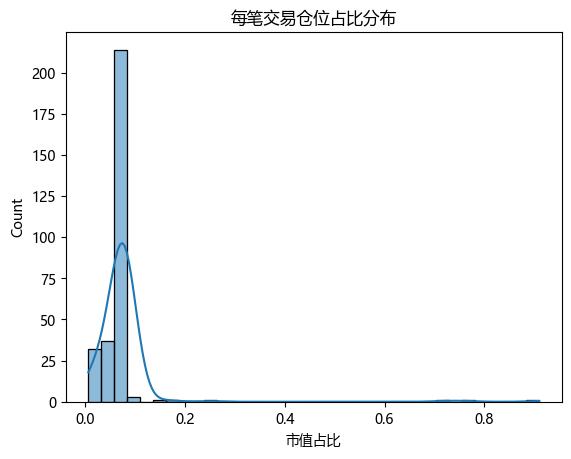

In [16]:
# 基金日收益率分布图
print(f"平均市值占比：{data['市值占比'].mean():.2%}")
sns.histplot(data['市值占比'], kde=True)
plt.title('每笔交易仓位占比分布')
plt.show()

In [17]:
print(f"重仓胜率：{len(data[(data["交易盈亏"] > 0) & (data["市值占比"] > 0.07)]) / len(data):.2%}")

重仓胜率：39.38%


In [18]:
print(f"重仓平均涨跌幅：{data[data["市值占比"]>0.07]['涨跌幅'].mean():.2%}")
print(f"重仓平均涨幅：{data[(data["市值占比"]>0.07) & (data["交易盈亏"]>0)]["涨跌幅"].mean():.2%}")
print(f"重仓平均跌幅：{data[(data["市值占比"]>0.07) & (data["交易盈亏"]<0)]["涨跌幅"].mean():.2%}")

重仓平均涨跌幅：1.29%
重仓平均涨幅：4.90%
重仓平均跌幅：-3.26%
